# pythia-features

In [1]:
from utils import plots, tables, utils
%matplotlib widget

In [2]:
# Knobs
data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_degree1.csv' # Max pooling, degree 1
baseline_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_baseline.csv'

seed = 1337
output_dir = './plots/pythia_features'
suites = {
    'SPEC 06': utils.spec06,
    #'SPEC 17': utils.spec17,
    #'GAP': utils.gap,
}
metrics  = [
    'ipc_improvement', 
    'L2C_issued_prefetches', 
    'L2C_accuracy', 
    'L2C_coverage',
    #'L2C_mpki_reduction', 
]
features = [
    # --- Current graphs ---
    {'Delta_Path', 'PC_Delta'},
    {'PC'},
    {'PC_Delta'},
    {'Delta_Path'},
    {'Address'},
    {'Delta'},
    {'Offset'},
    {'Page'}
]

# Pythia Features
Compare different Pythia features on different metrics. We see a greater difference when dynamic degree is disabled.

=== SPEC 06 ===


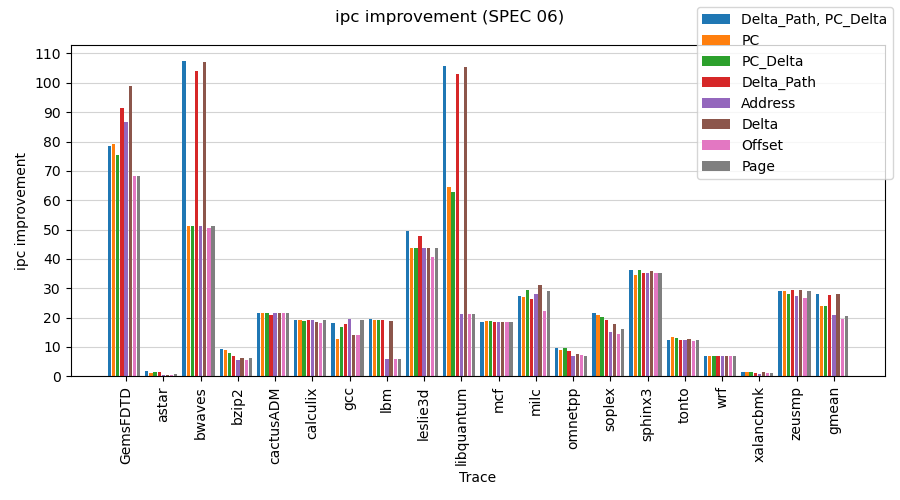

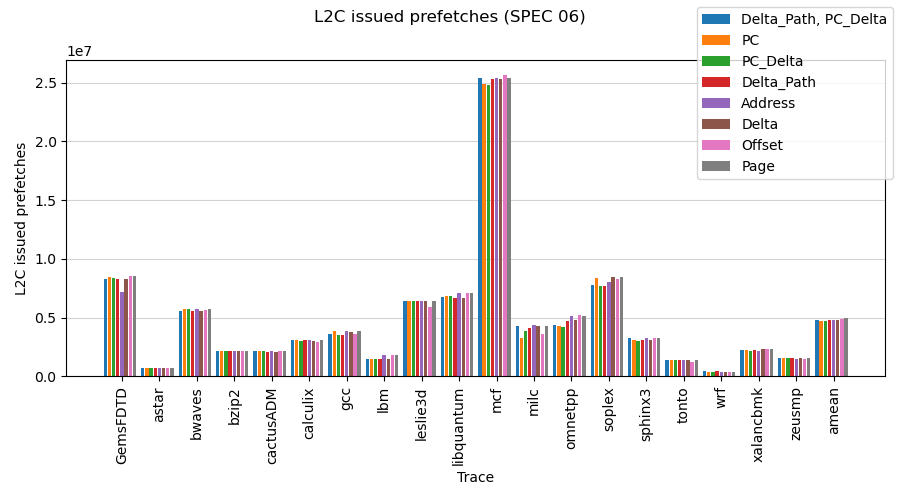

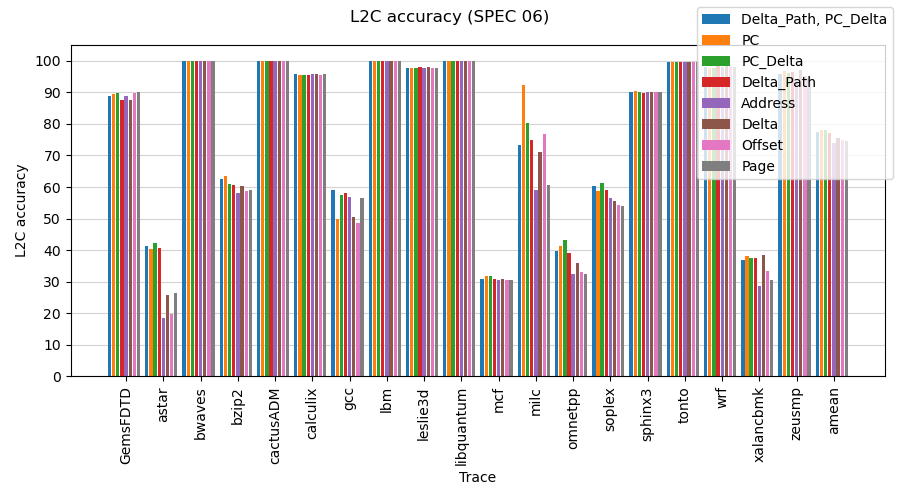

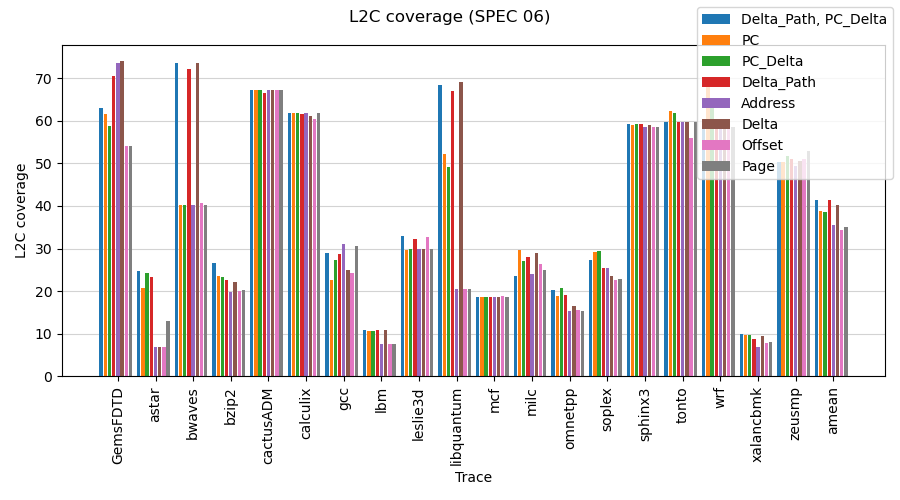

In [3]:
features_df = tables.load_stats_csv_pythia(data_path, features)
plots.plot_everything(features_df, suites=suites, metrics=metrics)

# Plots (suites)
Fix prefetch degree to 1 for everything (except Bingo), and compare to Bingo, SPP and Bingo+SPP hybrid.

In [4]:
pythia_deg1_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_degree1.csv' # Max pooling, degree 1
pythia_random_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_random.csv' # Max pooling, degree 1

pythia_deg1_df = tables.load_stats_csv_pythia(pythia_deg1_path, [{'PC_Delta'}, {'Delta_Path'}, {'PC_Delta', 'Delta_Path'}])
pythia_random_df = tables.load_stats_csv_pythia(pythia_random_path, [{'PC_Delta'}, {'Delta_Path'}, {'PC_Delta', 'Delta_Path'}])
baseline_df = tables.load_stats_csv(baseline_path, ['bingo', 'spp', 'bingo_spp', 'bo'])

## Pythia vs. everything

=== SPEC 06 ===


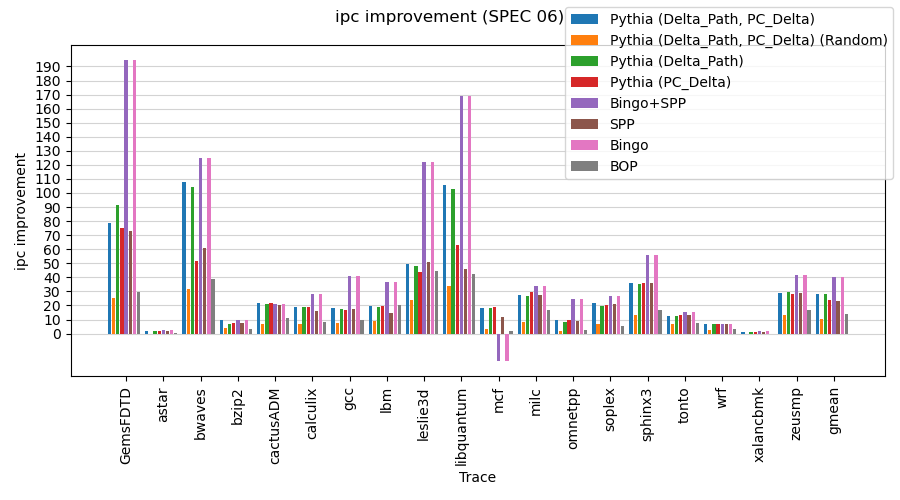

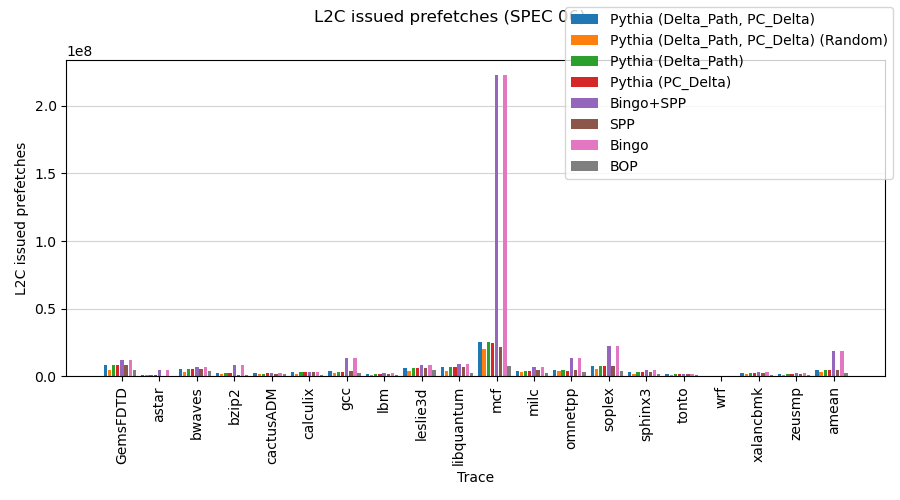

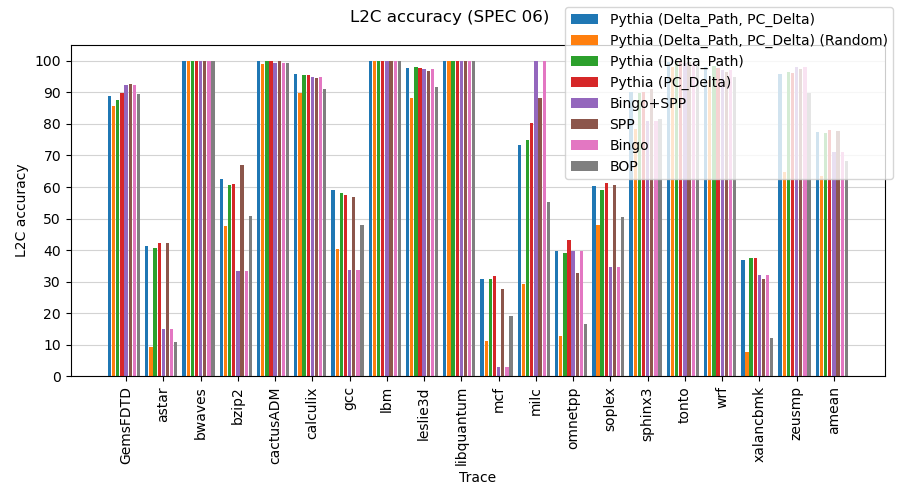

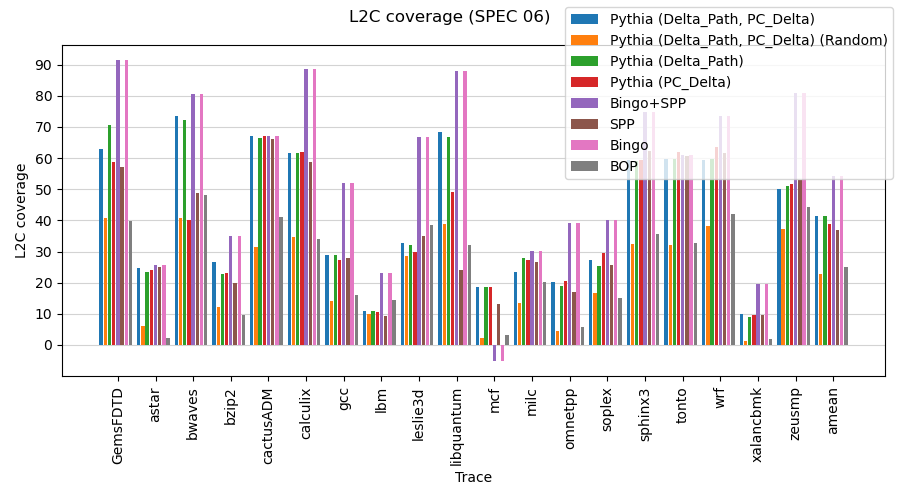

In [5]:
everything_df = {
    'Pythia (Delta_Path, PC_Delta)': pythia_deg1_df['Delta_Path, PC_Delta'],
    'Pythia (Delta_Path, PC_Delta) (Random)': pythia_random_df['Delta_Path, PC_Delta'],
    'Pythia (Delta_Path)': pythia_deg1_df['Delta_Path'],
    'Pythia (PC_Delta)': pythia_deg1_df['PC_Delta'],
    'Bingo+SPP': baseline_df['bingo_spp'],
    'SPP': baseline_df['spp'],
    'Bingo': baseline_df['bingo'],
    'BOP': baseline_df['bo']
}
plots.plot_everything(everything_df, suites=suites, metrics=metrics)


## Pythia vs. SPP

=== SPEC 06 ===


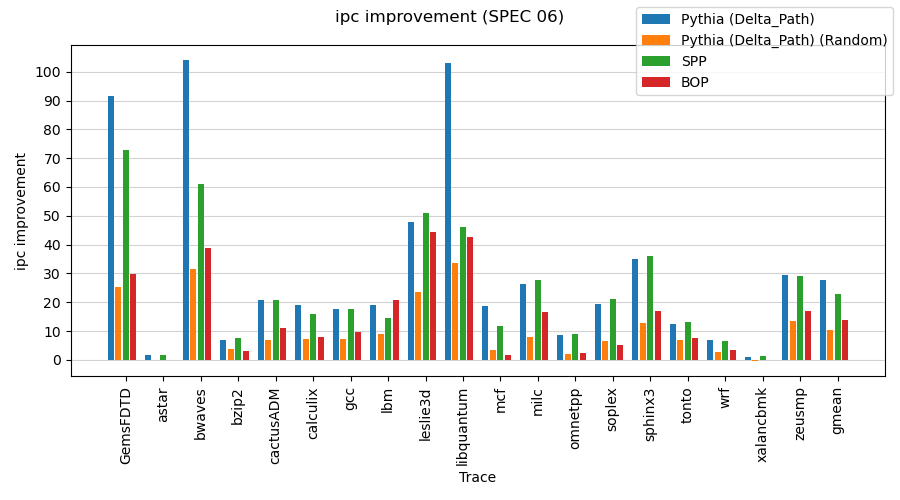

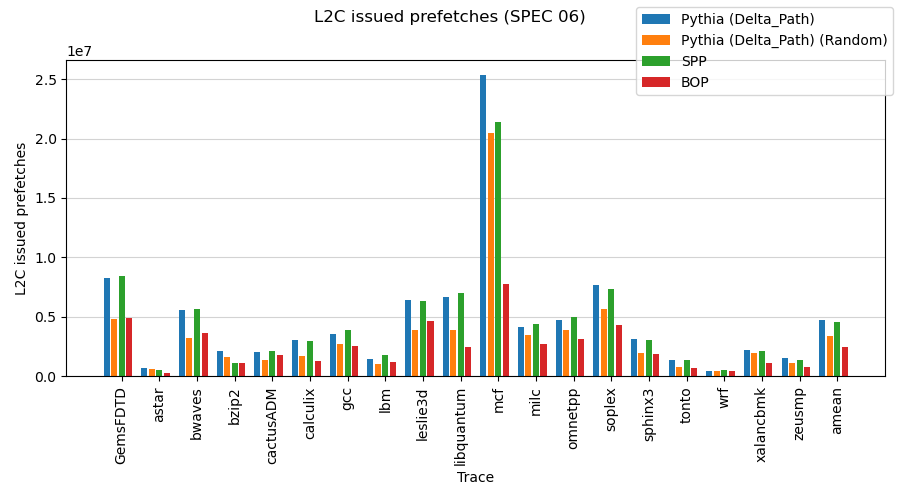

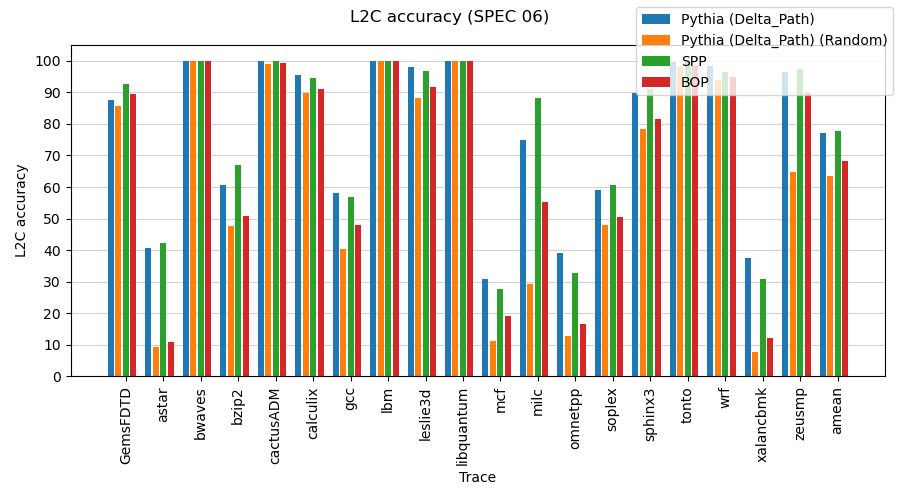

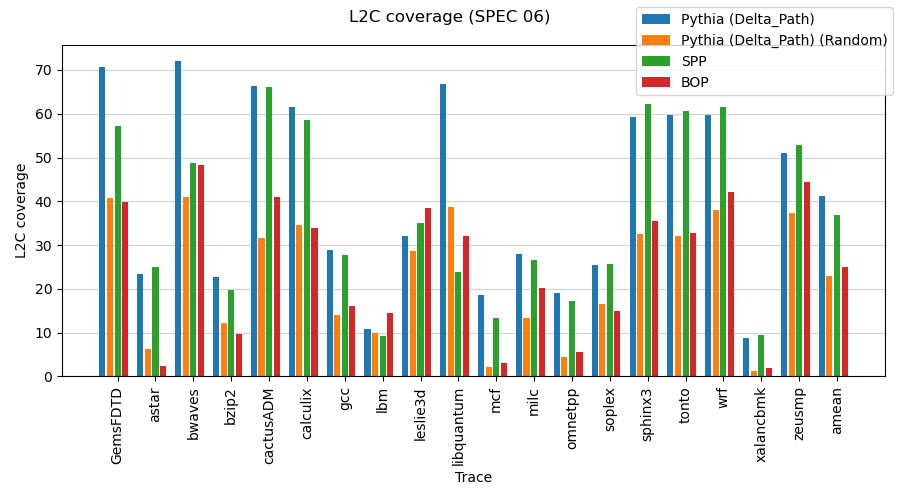

In [6]:
spp_df = {
    'Pythia (Delta_Path)': pythia_deg1_df['Delta_Path'],
    'Pythia (Delta_Path) (Random)': pythia_random_df['Delta_Path'],
    'SPP': baseline_df['spp'],
    'BOP': baseline_df['bo']
}
plots.plot_everything(spp_df, suites=suites, metrics=metrics)

## Pythia vs. Bingo

=== SPEC 06 ===


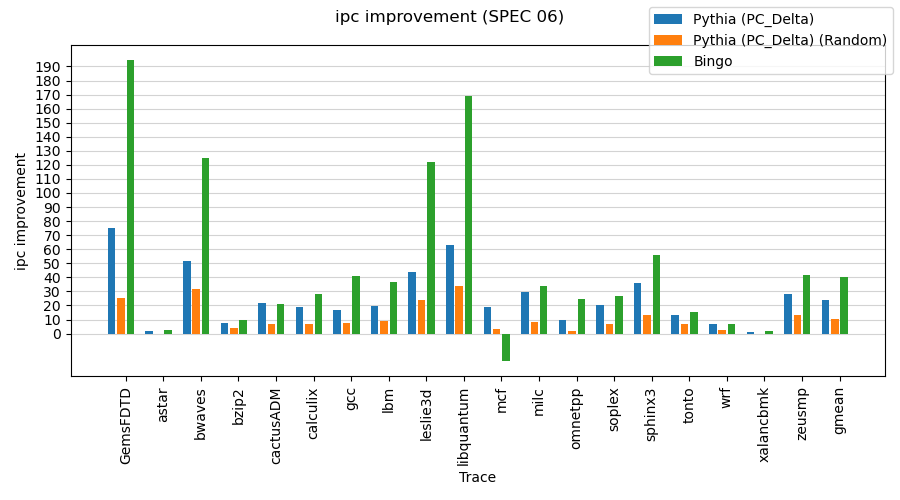

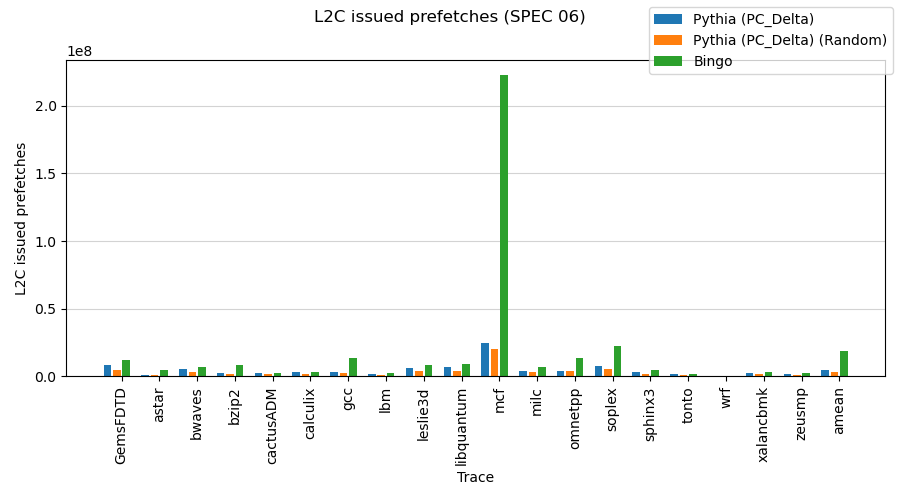

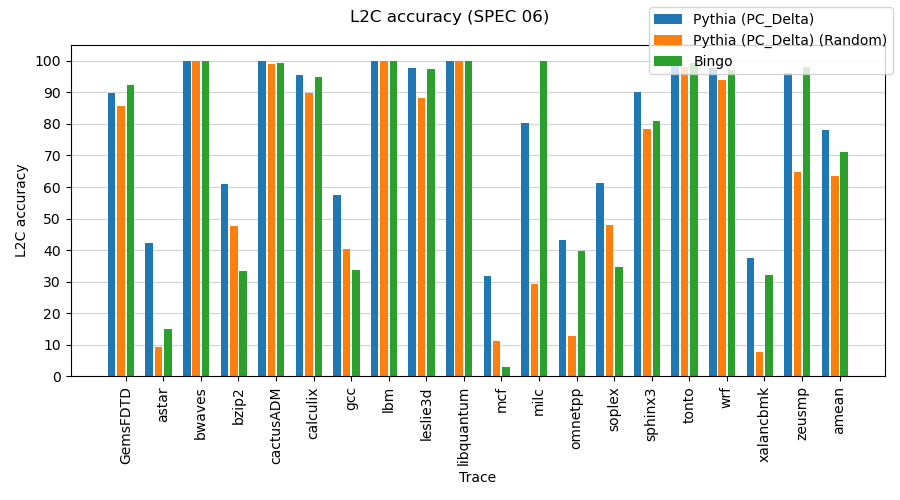

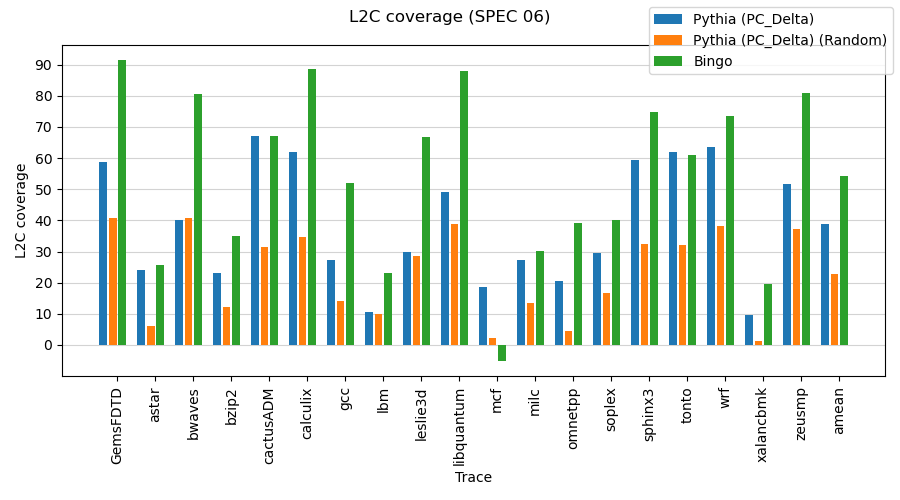

In [7]:
bingo_df = {
    'Pythia (PC_Delta)': pythia_deg1_df['PC_Delta'],
    'Pythia (PC_Delta) (Random)': pythia_random_df['PC_Delta'],
    'Bingo': baseline_df['bingo'],
}
plots.plot_everything(bingo_df, suites=suites, metrics=metrics)

## Pythia vs. SPP+Bingo

=== SPEC 06 ===


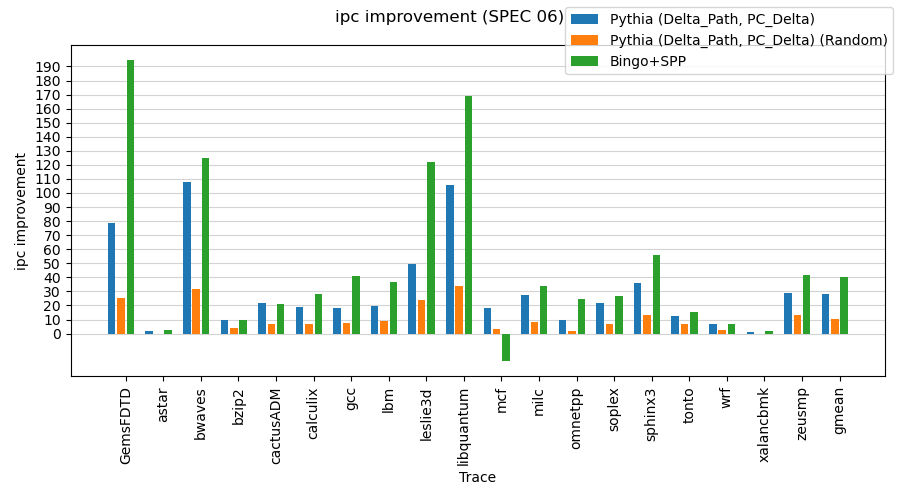

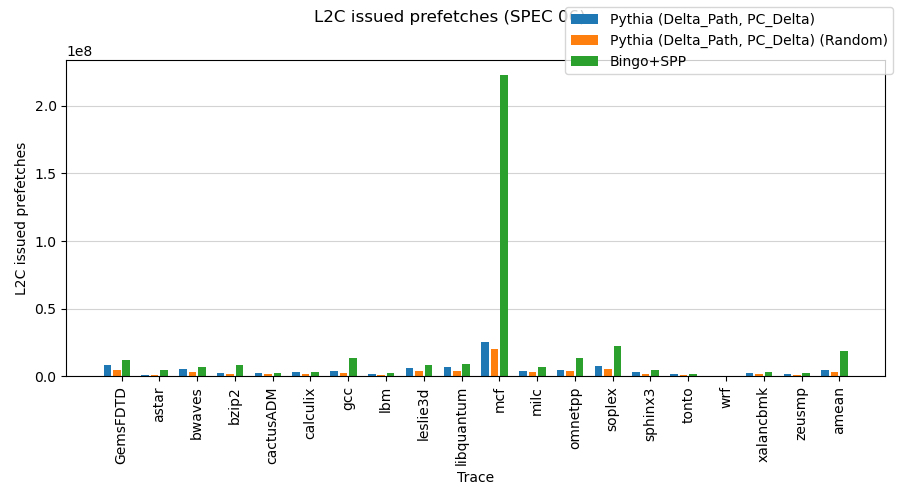

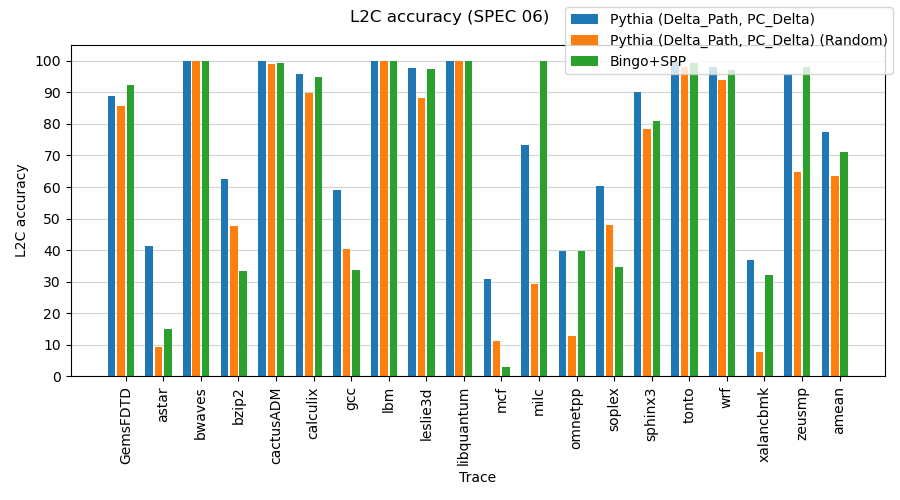

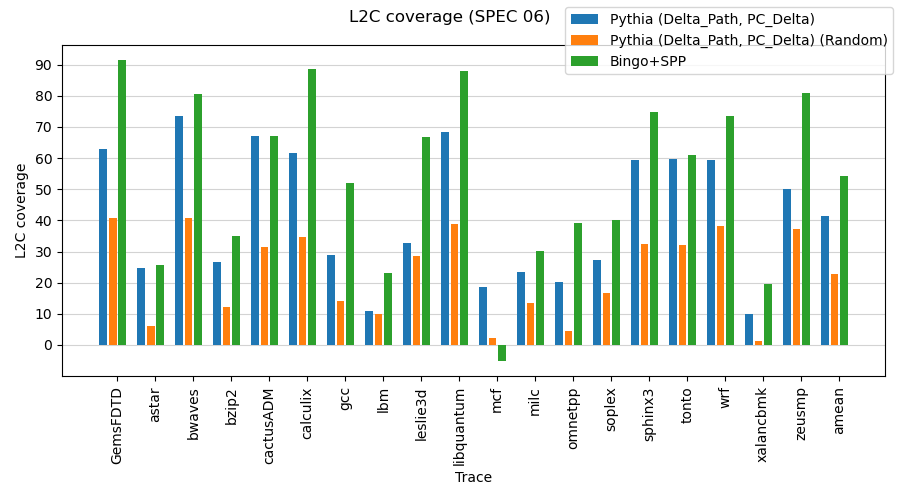

In [8]:
bingo_spp_df = {
    'Pythia (Delta_Path, PC_Delta)': pythia_deg1_df['Delta_Path, PC_Delta'],
    'Pythia (Delta_Path, PC_Delta) (Random)': pythia_random_df['Delta_Path, PC_Delta'],
    'Bingo+SPP': baseline_df['bingo_spp']
}
plots.plot_everything(bingo_spp_df, suites=suites, metrics=metrics)

# Plots (single benchmarks)
Compare versions of Pythia to SPP, Bingo, BOP on libquantum.

## libquantum: Pythia vs. SPP, BOP

libquantum


/u/cmolder/GitHub/pythia-analysis/utils/plots.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=dpi, figsize=figsize)


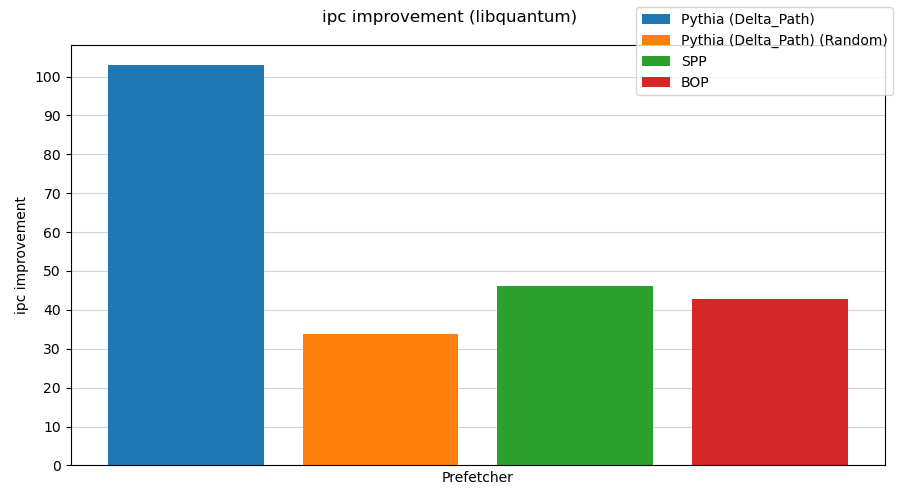

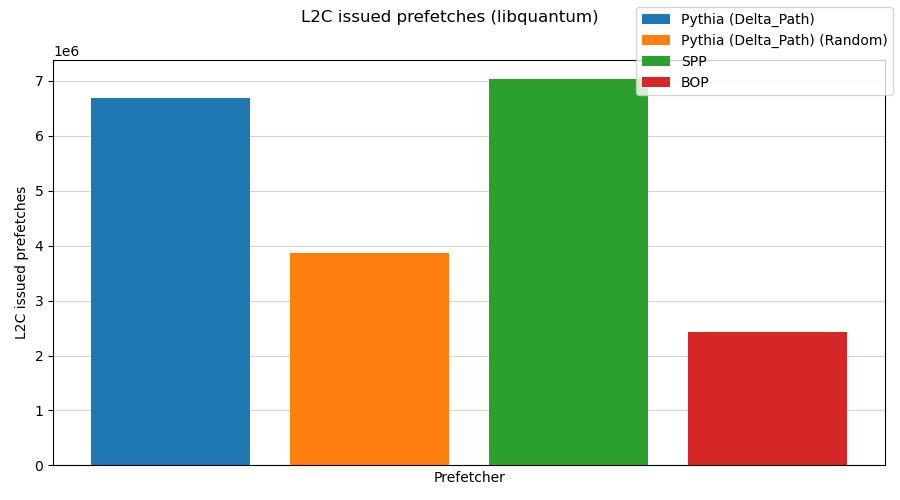

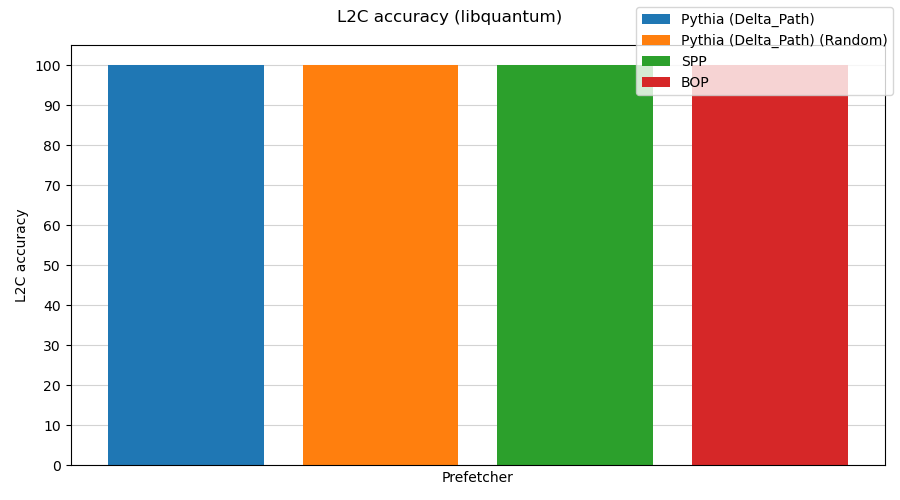

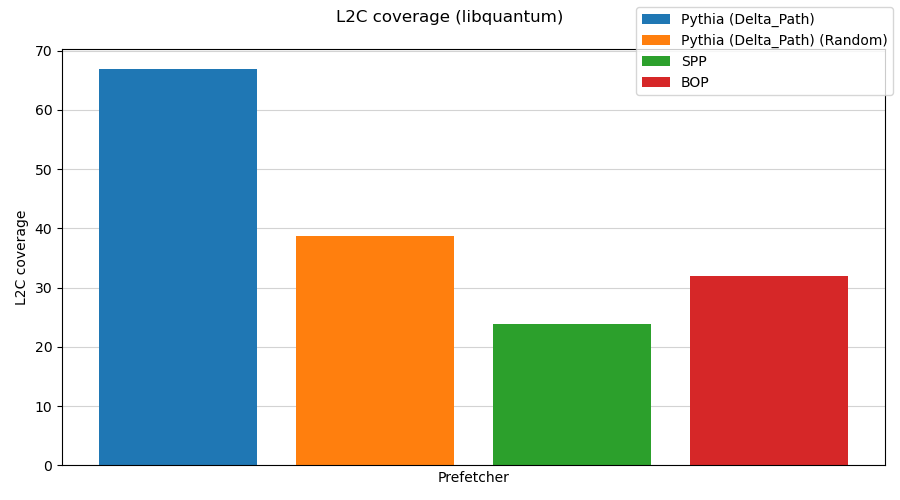

In [9]:
single_spp_df = {
    'Pythia (Delta_Path)': pythia_deg1_df['Delta_Path'],
    'Pythia (Delta_Path) (Random)': pythia_random_df['Delta_Path'],
    'SPP': baseline_df['spp'],
    'BOP': baseline_df['bo'],
}
plots.plot_everything_benchmark(single_spp_df, ['libquantum'], metrics=metrics)

## libquantum: Pythia vs. Bingo

libquantum


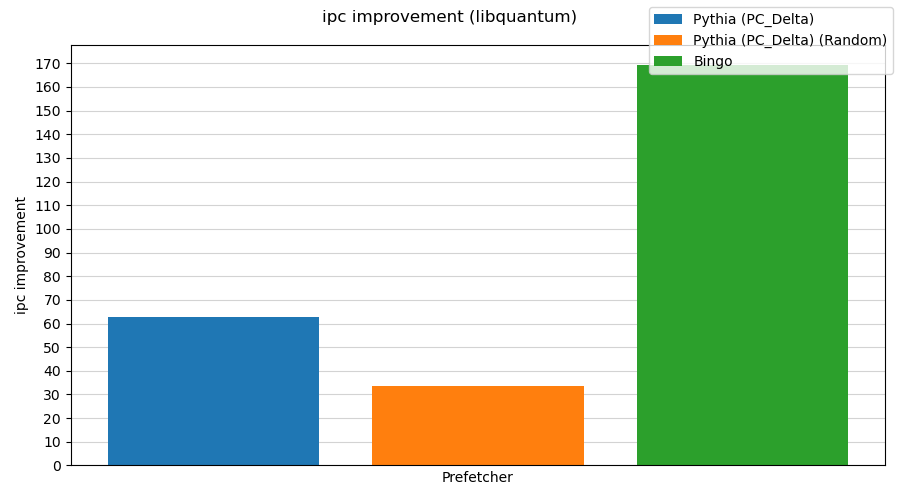

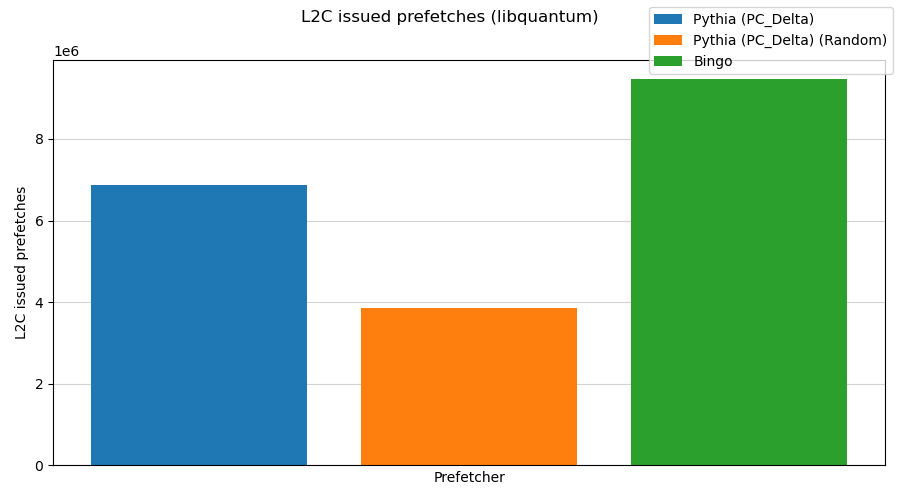

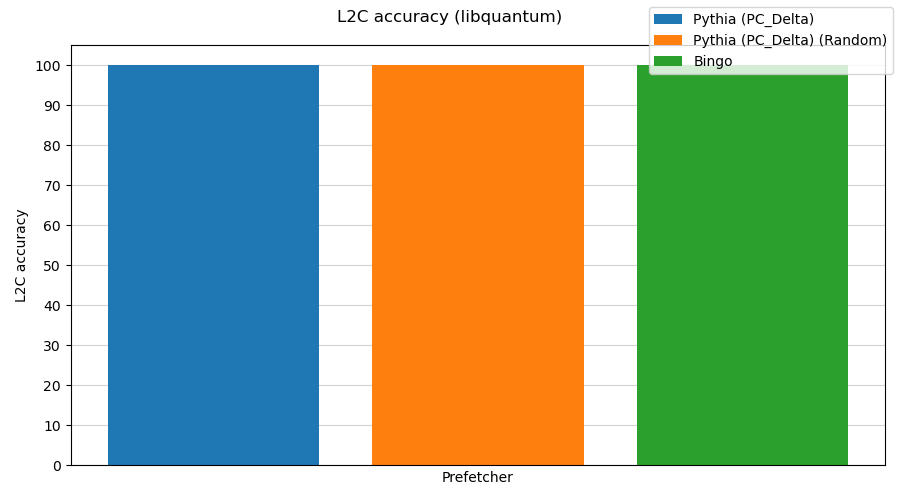

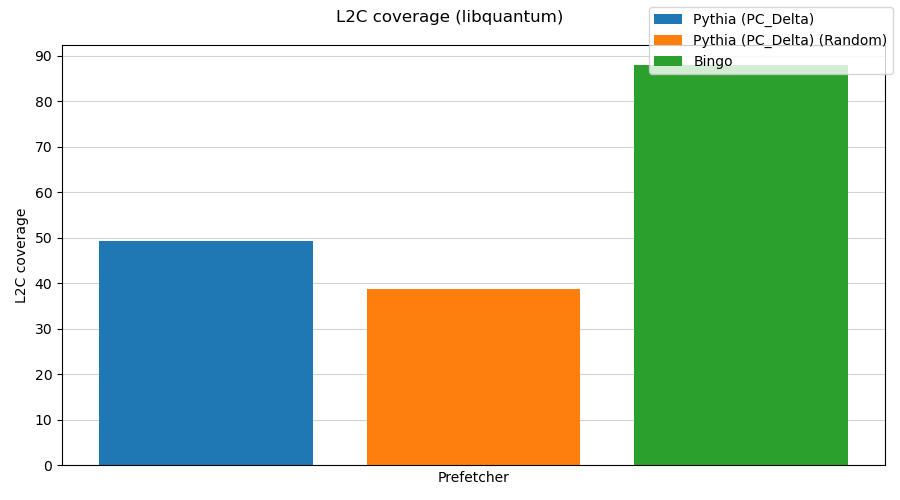

In [10]:
single_bingo_df = {
    'Pythia (PC_Delta)': pythia_deg1_df['PC_Delta'],
    'Pythia (PC_Delta) (Random)': pythia_random_df['PC_Delta'],
    'Bingo': baseline_df['bingo'],
}
plots.plot_everything_benchmark(single_bingo_df, ['libquantum'], metrics=metrics)

## libquantum: Pythia vs. SPP+Bingo

libquantum


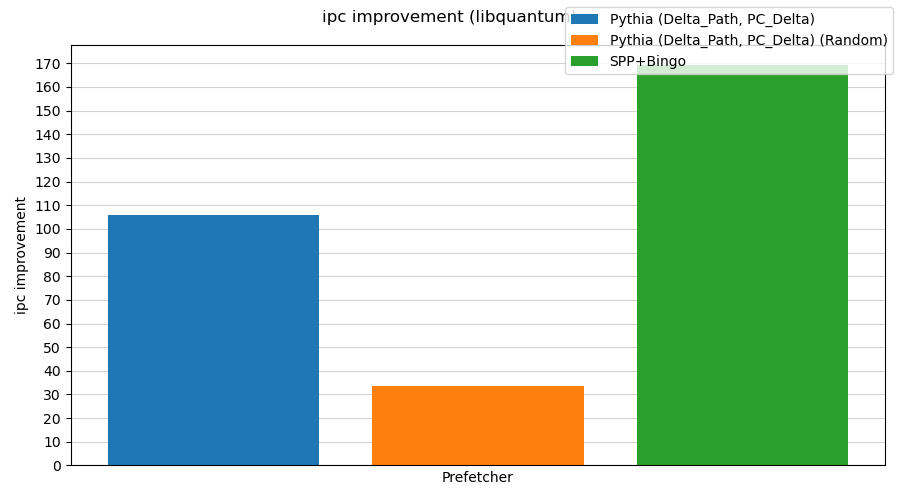

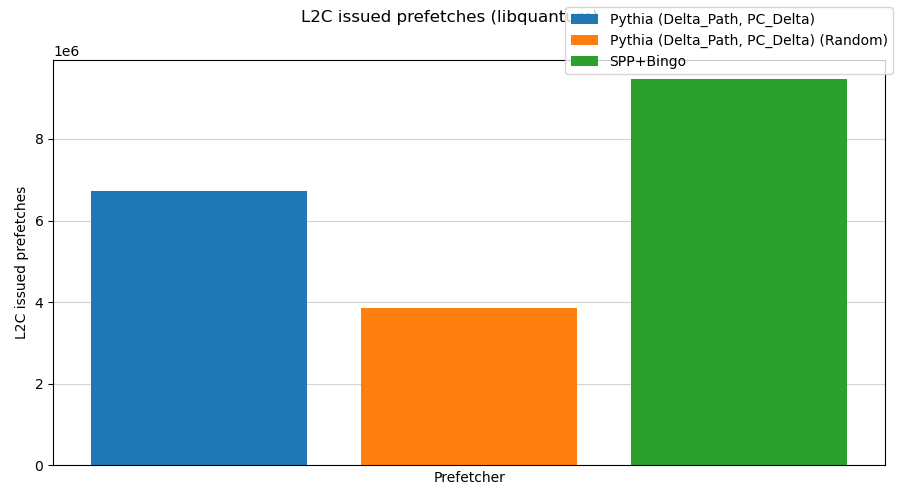

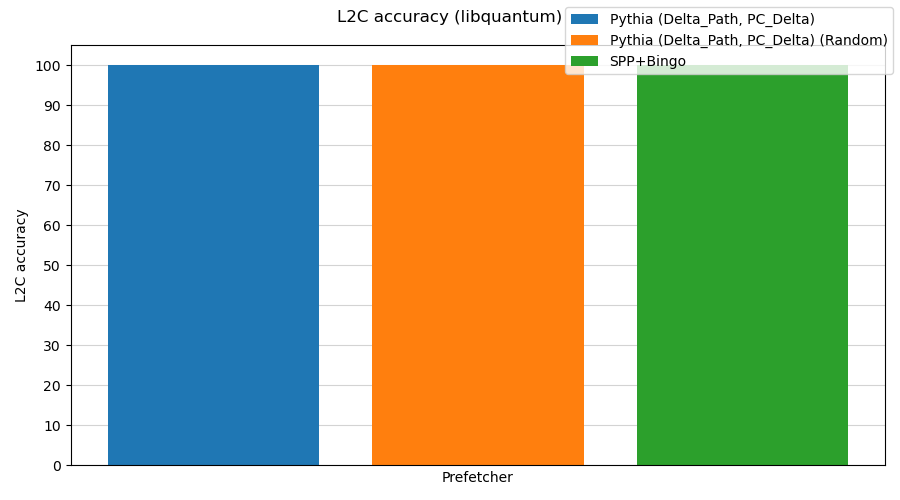

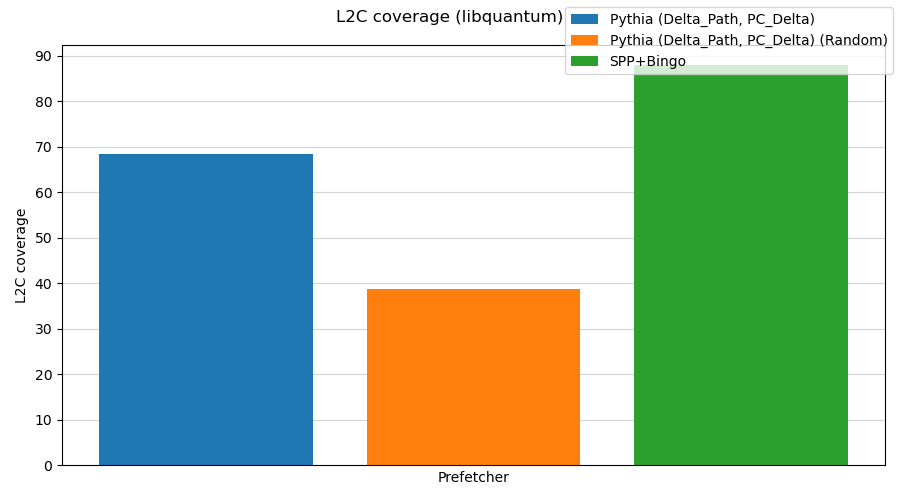

In [11]:
single_hybrid_df = {
    'Pythia (Delta_Path, PC_Delta)': pythia_deg1_df['Delta_Path, PC_Delta'],
    'Pythia (Delta_Path, PC_Delta) (Random)': pythia_random_df['Delta_Path, PC_Delta'],
    'SPP+Bingo': baseline_df['bingo_spp'],
}
plots.plot_everything_benchmark(single_hybrid_df, ['libquantum'], metrics=metrics)

## libquantum: Pythia vs. everything

libquantum


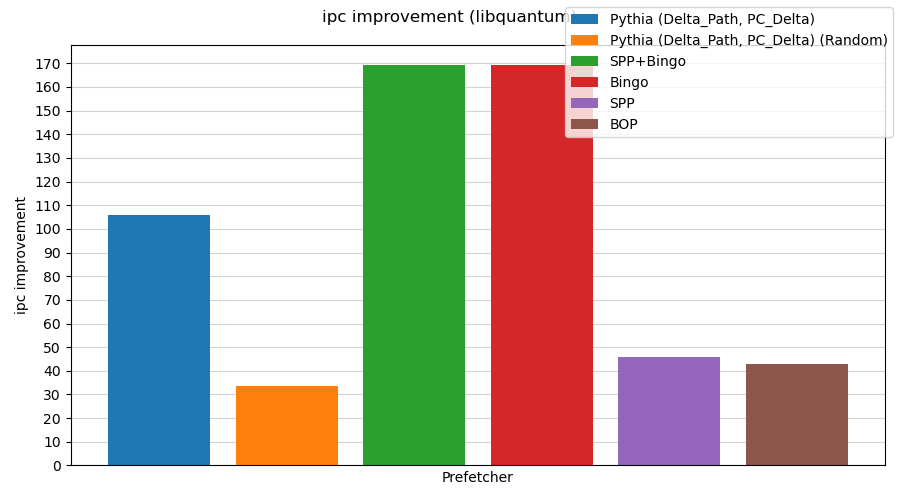

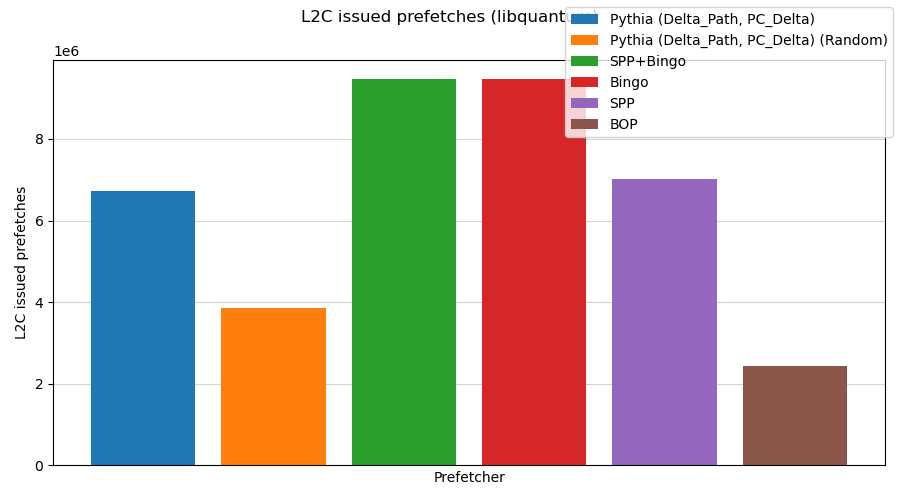

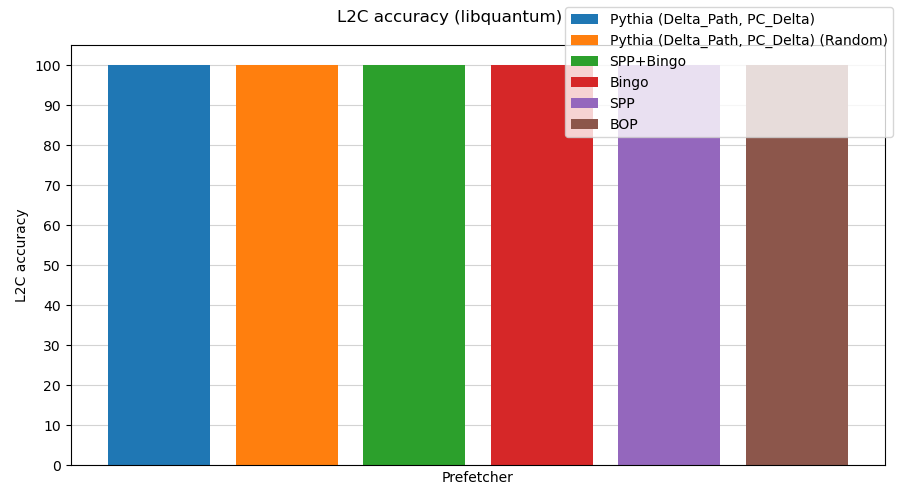

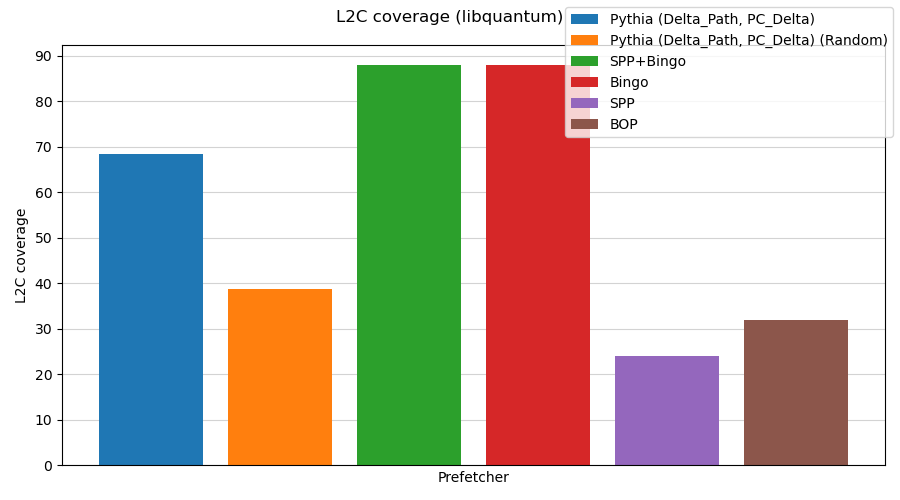

In [12]:
single_everything_df = {
    'Pythia (Delta_Path, PC_Delta)': pythia_deg1_df['Delta_Path, PC_Delta'],
    'Pythia (Delta_Path, PC_Delta) (Random)': pythia_random_df['Delta_Path, PC_Delta'],
    'SPP+Bingo': baseline_df['bingo_spp'],
    'Bingo': baseline_df['bingo'],
    'SPP': baseline_df['spp'],
    'BOP': baseline_df['bo']
}
plots.plot_everything_benchmark(single_everything_df, ['libquantum'], metrics=metrics)

# Tables

## Pythia features

In [13]:
tables.table_everything(features_df, suites=suites, metrics=metrics)

=== SPEC 06 ===
Delta_Path, PC_Delta


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,78.32,8253000,88.99,62.93
astar,1.67,739271,41.46,24.72
bwaves,107.52,5585077,100.00,73.65
bzip2,9.36,2123836,62.69,26.60
cactusADM,21.43,2116505,99.92,67.21
calculix,19.26,3072972,95.67,61.78
gcc,18.02,3619130,58.93,29.04
lbm,19.40,1471458,99.98,10.77
leslie3d,49.46,6384132,97.86,32.89


PC


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,79.19,8419242,89.59,61.68
astar,1.29,741478,40.29,20.75
bwaves,51.14,5710915,100.00,40.21
bzip2,8.83,2139586,63.37,23.50
cactusADM,21.43,2116479,99.92,67.21
calculix,19.10,3060981,95.47,61.74
gcc,12.75,3833252,49.90,22.72
lbm,19.32,1471239,99.97,10.75
leslie3d,43.83,6423601,97.67,29.78


PC_Delta


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,75.41,8398692,89.83,58.80
astar,1.54,734670,42.21,24.22
bwaves,51.28,5709285,100.00,40.22
bzip2,7.80,2159039,61.09,23.25
cactusADM,21.43,2116488,99.92,67.21
calculix,18.99,3050004,95.55,61.90
gcc,16.84,3527128,57.59,27.33
lbm,19.36,1472733,99.99,10.72
leslie3d,43.82,6408439,97.65,29.98


Delta_Path


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,91.43,8266236,87.52,70.60
astar,1.56,738218,40.79,23.40
bwaves,104.04,5585500,100.00,72.11
bzip2,6.90,2155055,60.53,22.63
cactusADM,20.85,2072324,99.91,66.43
calculix,19.12,3054607,95.65,61.48
gcc,17.79,3544839,58.17,28.76
lbm,19.11,1482918,99.98,10.83
leslie3d,47.82,6395978,98.01,32.18


Address


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,86.59,7222947,88.76,73.60
astar,0.38,719275,18.52,7.00
bwaves,51.20,5710974,100.00,40.21
bzip2,5.44,2162640,58.19,19.73
cactusADM,21.43,2116479,99.92,67.21
calculix,19.26,3072959,95.67,61.78
gcc,19.37,3876413,56.89,30.97
lbm,5.75,1852267,99.98,7.51
leslie3d,43.89,6439092,97.69,29.86


Delta


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,98.99,8247706,87.69,74.08
astar,0.39,742248,25.94,6.93
bwaves,107.09,5579020,100.00,73.65
bzip2,6.41,2179397,60.28,22.13
cactusADM,21.42,2100825,99.91,67.18
calculix,18.58,3021327,95.68,61.16
gcc,14.06,3760033,50.61,25.05
lbm,18.81,1453748,99.98,10.85
leslie3d,43.89,6400376,97.91,29.80


Offset


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,68.28,8522431,89.87,54.00
astar,0.38,735333,19.76,6.99
bwaves,50.44,5622112,100.00,40.65
bzip2,5.54,2167785,58.70,19.92
cactusADM,21.44,2117121,99.92,67.21
calculix,18.09,2934573,95.54,60.35
gcc,14.13,3646636,48.60,24.36
lbm,6.01,1823236,99.98,7.57
leslie3d,40.58,5936455,97.68,32.63


Page


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,68.26,8521069,90.01,54.00
astar,0.84,720238,26.35,12.92
bwaves,51.20,5710976,100.00,40.21
bzip2,6.27,2159936,58.97,20.37
cactusADM,21.43,2116404,99.92,67.21
calculix,19.24,3072889,95.67,61.77
gcc,19.11,3884959,56.46,30.69
lbm,5.76,1852475,99.98,7.52
leslie3d,43.89,6439189,97.69,29.89


## Pythia vs. everything (degree 1)

In [14]:
tables.table_everything(everything_df, suites=suites, metrics=metrics)

=== SPEC 06 ===
Pythia (Delta_Path, PC_Delta)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,78.32,8253000,88.99,62.93
astar,1.67,739271,41.46,24.72
bwaves,107.52,5585077,100.00,73.65
bzip2,9.36,2123836,62.69,26.60
cactusADM,21.43,2116505,99.92,67.21
calculix,19.26,3072972,95.67,61.78
gcc,18.02,3619130,58.93,29.04
lbm,19.40,1471458,99.98,10.77
leslie3d,49.46,6384132,97.86,32.89


Pythia (Delta_Path, PC_Delta) (Random)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,25.19,4857298,85.69,40.68
astar,-0.14,650390,9.20,6.15
bwaves,31.47,3211129,99.88,40.90
bzip2,3.76,1608015,47.53,12.08
cactusADM,7.05,1402459,99.02,31.54
calculix,7.09,1716919,89.95,34.55
gcc,7.41,2731754,40.30,14.03
lbm,9.09,1010291,99.96,9.84
leslie3d,23.69,3924346,88.14,28.60


Pythia (Delta_Path)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,91.43,8266236,87.52,70.60
astar,1.56,738218,40.79,23.40
bwaves,104.04,5585500,100.00,72.11
bzip2,6.90,2155055,60.53,22.63
cactusADM,20.85,2072324,99.91,66.43
calculix,19.12,3054607,95.65,61.48
gcc,17.79,3544839,58.17,28.76
lbm,19.11,1482918,99.98,10.83
leslie3d,47.82,6395978,98.01,32.18


Pythia (PC_Delta)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,75.41,8398692,89.83,58.80
astar,1.54,734670,42.21,24.22
bwaves,51.28,5709285,100.00,40.22
bzip2,7.80,2159039,61.09,23.25
cactusADM,21.43,2116488,99.92,67.21
calculix,18.99,3050004,95.55,61.90
gcc,16.84,3527128,57.59,27.33
lbm,19.36,1472733,99.99,10.72
leslie3d,43.82,6408439,97.65,29.98


Bingo+SPP


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,194.54,12422623,92.20,91.46
astar,2.37,4602183,15.12,25.76
bwaves,124.63,6637883,100.00,80.64
bzip2,9.89,8344178,33.42,35.06
cactusADM,20.77,2202180,99.22,67.00
calculix,27.85,3576877,94.84,88.70
gcc,41.20,13897961,33.84,52.00
lbm,36.50,2737625,100.00,23.00
leslie3d,121.76,8140206,97.35,66.73


SPP


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,72.90,8416634,92.65,57.19
astar,1.67,574660,42.10,25.09
bwaves,61.00,5679682,100.00,48.66
bzip2,7.60,1113085,67.13,19.76
cactusADM,20.66,2090450,99.89,66.22
calculix,15.81,2978230,94.67,58.59
gcc,17.57,3903476,56.94,27.82
lbm,14.42,1834308,100.00,9.18
leslie3d,51.14,6346392,96.63,34.93


Bingo


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,194.54,12422623,92.20,91.46
astar,2.37,4602183,15.12,25.76
bwaves,124.63,6637883,100.00,80.64
bzip2,9.89,8344178,33.42,35.06
cactusADM,20.77,2202180,99.22,67.00
calculix,27.85,3576877,94.84,88.70
gcc,41.20,13897961,33.84,52.00
lbm,36.50,2737625,100.00,23.00
leslie3d,121.76,8140206,97.35,66.73


BOP


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,29.80,4938834,89.38,39.88
astar,0.08,257611,10.76,2.35
bwaves,39.00,3685289,99.91,48.23
bzip2,3.01,1105269,50.69,9.77
cactusADM,11.11,1805921,99.28,41.00
calculix,8.05,1314663,91.18,33.96
gcc,9.58,2515844,47.91,16.02
lbm,20.67,1189453,99.98,14.55
leslie3d,44.22,4624318,91.67,38.54


## Pythia vs. SPP (degree 1)

In [15]:
tables.table_everything(spp_df, suites=suites, metrics=metrics)

=== SPEC 06 ===
Pythia (Delta_Path)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,91.43,8266236,87.52,70.60
astar,1.56,738218,40.79,23.40
bwaves,104.04,5585500,100.00,72.11
bzip2,6.90,2155055,60.53,22.63
cactusADM,20.85,2072324,99.91,66.43
calculix,19.12,3054607,95.65,61.48
gcc,17.79,3544839,58.17,28.76
lbm,19.11,1482918,99.98,10.83
leslie3d,47.82,6395978,98.01,32.18


Pythia (Delta_Path) (Random)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,25.19,4857298,85.69,40.68
astar,-0.14,650390,9.20,6.15
bwaves,31.47,3211129,99.88,40.90
bzip2,3.76,1608015,47.53,12.08
cactusADM,7.05,1402459,99.02,31.54
calculix,7.09,1716919,89.95,34.55
gcc,7.41,2731754,40.30,14.03
lbm,9.09,1010291,99.96,9.84
leslie3d,23.69,3924346,88.14,28.60


SPP


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,72.90,8416634,92.65,57.19
astar,1.67,574660,42.10,25.09
bwaves,61.00,5679682,100.00,48.66
bzip2,7.60,1113085,67.13,19.76
cactusADM,20.66,2090450,99.89,66.22
calculix,15.81,2978230,94.67,58.59
gcc,17.57,3903476,56.94,27.82
lbm,14.42,1834308,100.00,9.18
leslie3d,51.14,6346392,96.63,34.93


BOP


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,29.80,4938834,89.38,39.88
astar,0.08,257611,10.76,2.35
bwaves,39.00,3685289,99.91,48.23
bzip2,3.01,1105269,50.69,9.77
cactusADM,11.11,1805921,99.28,41.00
calculix,8.05,1314663,91.18,33.96
gcc,9.58,2515844,47.91,16.02
lbm,20.67,1189453,99.98,14.55
leslie3d,44.22,4624318,91.67,38.54


## Pythia vs. Bingo (degree 1)

In [16]:
tables.table_everything(bingo_df, suites=suites, metrics=metrics)

=== SPEC 06 ===
Pythia (PC_Delta)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,75.41,8398692,89.83,58.80
astar,1.54,734670,42.21,24.22
bwaves,51.28,5709285,100.00,40.22
bzip2,7.80,2159039,61.09,23.25
cactusADM,21.43,2116488,99.92,67.21
calculix,18.99,3050004,95.55,61.90
gcc,16.84,3527128,57.59,27.33
lbm,19.36,1472733,99.99,10.72
leslie3d,43.82,6408439,97.65,29.98


Pythia (PC_Delta) (Random)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,25.19,4857298,85.69,40.68
astar,-0.14,650390,9.20,6.15
bwaves,31.47,3211129,99.88,40.90
bzip2,3.76,1608015,47.53,12.08
cactusADM,7.05,1402459,99.02,31.54
calculix,7.09,1716919,89.95,34.55
gcc,7.41,2731754,40.30,14.03
lbm,9.09,1010291,99.96,9.84
leslie3d,23.69,3924346,88.14,28.60


Bingo


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,194.54,12422623,92.20,91.46
astar,2.37,4602183,15.12,25.76
bwaves,124.63,6637883,100.00,80.64
bzip2,9.89,8344178,33.42,35.06
cactusADM,20.77,2202180,99.22,67.00
calculix,27.85,3576877,94.84,88.70
gcc,41.20,13897961,33.84,52.00
lbm,36.50,2737625,100.00,23.00
leslie3d,121.76,8140206,97.35,66.73


## Pythia vs. SPP+Bingo

In [17]:
tables.table_everything(bingo_spp_df, suites=suites, metrics=metrics)

=== SPEC 06 ===
Pythia (Delta_Path, PC_Delta)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,78.32,8253000,88.99,62.93
astar,1.67,739271,41.46,24.72
bwaves,107.52,5585077,100.00,73.65
bzip2,9.36,2123836,62.69,26.60
cactusADM,21.43,2116505,99.92,67.21
calculix,19.26,3072972,95.67,61.78
gcc,18.02,3619130,58.93,29.04
lbm,19.40,1471458,99.98,10.77
leslie3d,49.46,6384132,97.86,32.89


Pythia (Delta_Path, PC_Delta) (Random)


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,25.19,4857298,85.69,40.68
astar,-0.14,650390,9.20,6.15
bwaves,31.47,3211129,99.88,40.90
bzip2,3.76,1608015,47.53,12.08
cactusADM,7.05,1402459,99.02,31.54
calculix,7.09,1716919,89.95,34.55
gcc,7.41,2731754,40.30,14.03
lbm,9.09,1010291,99.96,9.84
leslie3d,23.69,3924346,88.14,28.60


Bingo+SPP


,ipc_improvement,L2C_issued_prefetches,L2C_accuracy,L2C_coverage
trace,,,,
GemsFDTD,194.54,12422623,92.20,91.46
astar,2.37,4602183,15.12,25.76
bwaves,124.63,6637883,100.00,80.64
bzip2,9.89,8344178,33.42,35.06
cactusADM,20.77,2202180,99.22,67.00
calculix,27.85,3576877,94.84,88.70
gcc,41.20,13897961,33.84,52.00
lbm,36.50,2737625,100.00,23.00
leslie3d,121.76,8140206,97.35,66.73
